In [1]:
import os
from os import listdir
from os.path import isfile, join

import pandas as pd
from itertools import islice
import numpy as np

from skimage.external import tifffile
from skimage.external.tifffile import imread

import matplotlib.pyplot as plt

import ipywidgets as widgets

import random


from scipy.ndimage.morphology import binary_erosion as br
from skimage import morphology as skmor

from scipy import ndimage
from PIL import Image, ImageDraw

import numpy.ma as ma

from skimage.measure import label, regionprops

In [2]:
bigDir = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\new dataset'

In [3]:
cellDataFile=f'{bigDir}\cellinfo_final_v1.csv'
cellData=pd.read_csv(cellDataFile)
cellData.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,...,DAPI ch,DIC ch,category,molecular age,physical age [min],imaging core,cell id for tracking,comment,molecular age 10,path
0,0,0,1,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,...,3,4,middle G1,0.444,340.0,HIC,17,NaN,0.311,Z:\CookLab\Liu\20190816_organizedData_MCM_load...
1,1,1,2,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,...,3,4,G2,1.373,NaN,HIC,20,110 min after s,2.036,Z:\CookLab\Liu\20190816_organizedData_MCM_load...
2,2,2,3,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,...,3,4,G2,1.371,910.0,HIC,23,30 min after S,1.960,Z:\CookLab\Liu\20190816_organizedData_MCM_load...
3,3,3,4,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,...,3,4,early G1,0.704,30.0,HIC,25,NaN,0.632,Z:\CookLab\Liu\20190816_organizedData_MCM_load...
4,4,4,5,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,...,3,4,middle G1,0.345,250.0,HIC,32,NaN,0.225,Z:\CookLab\Liu\20190816_organizedData_MCM_load...


In [4]:
cellData=cellData.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

# 200129 Segment heterochromatin by percentile

In [5]:
i=29
het_percentile=20
# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(cellData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,myCell in islice(cellData.iterrows(), i,None):

    # create folder to store this percentile data if it doesn't exist yet
    newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}')
    newResultsFolder = os.path.dirname(myCell.path).replace('data_tiff', 'results')
    
    try:
        os.mkdir(newSegFolder)
    except:
        pass
    
    try:
        os.mkdir(newResultsFolder)
    except:
        pass

    
    # open tiff image of a cell
    try:
        myImage=imread(myCell.path)    
    except:
        myCell.path=myCell.path.replace('.tif','.tiff')
        myImage=imread(myCell.path)    


    myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

    # open nucleus mask
    nucleusMaskPath=myCell.path
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    try:
        nucleusMask=imread(nucleusMaskPath)
    except:
        nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
        nucleusMask=imread(nucleusMaskPath)


    # make nucleus mask binary
    nucleusMask = nucleusMask.astype(bool)

    # clean image
    myNucleus = myChannel[nucleusMask]

    # find threshold
    myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

    # threshold
    myHetMask=np.zeros(myChannel.shape).astype('bool')
    myHetMask[myChannel >= myPercentile] = 1
    
    # clean from elements outside the nucleus
    cleanNucleusMask=~nucleusMask
    myHetMask[cleanNucleusMask]=0
    cleanHetMask = ~myHetMask

    # save segmentation mask
    maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), myHetMask.astype('uint8'))

    # calculate signals
    df = pd.DataFrame(columns = ['HetChrom_Volume','HetChrom_total_ch1','HetChrom_total_ch2','HetChrom_total_ch3',
                                 'Slice'])

    df.Slice = range(myChannel.shape[0])
    df.HetChrom_Volume =  myHetMask.sum(-1).sum(-1)

    for ch in range(3):
        myChannel = myImage[:, ch, :, :]
        myChannel[cleanHetMask] = 0
        signal = myChannel.sum(-1).sum(-1)
        exec(f'df.HetChrom_total_ch{ch}=signal')

    # save signals
    dfSavePath=myCell.path
    dfSavePath=dfSavePath.replace('data_tiff','results')
    dfSavePath=dfSavePath.replace('.tif',f'_hetChrom_{str((het_percentile))}.csv')
    df.to_csv(dfSavePath)

    # add info to cell info file
    cellData.loc[i,f'hetChrom_{str(het_percentile)}_volume']=np.sum(df.HetChrom_Volume)
    for ch in range(3):
        exec(f"cellData.loc[i,'hetChrom_{str(het_percentile)}perc_ch{ch+1}']=np.sum(df.HetChrom_total_ch{ch})") 

    progBar.value=progBar.value+1
    
    break

IntProgress(value=29, description='Progress:', max=324)

C:\ProgramData\Anaconda3_reinstalled\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


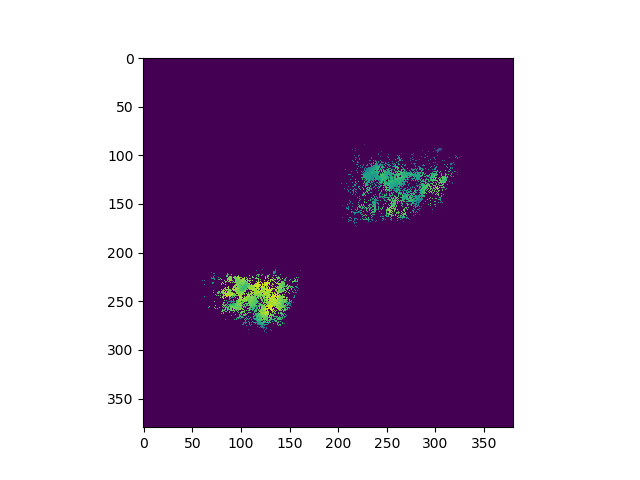

In [7]:
%matplotlib notebook
plt.imshow(myChannel[20])

In [37]:
cellData.head()

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,physical age [min],imaging core,cell id for tracking,comment,molecular age 10,path,hetChrom_20_volume,hetChrom_20perc_ch1,hetChrom_20perc_ch2,hetChrom_20perc_ch3
0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,3,...,340.0,HIC,17,NaN,0.311,Z:\CookLab\Liu\20190816_organizedData_MCM_load...,52642.0,790208510.0,550518042.0,1.061172e+09
1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,NaN,HIC,20,110 min after s,2.036,Z:\CookLab\Liu\20190816_organizedData_MCM_load...,NaN,NaN,NaN,NaN
2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,3,...,910.0,HIC,23,30 min after S,1.960,Z:\CookLab\Liu\20190816_organizedData_MCM_load...,NaN,NaN,NaN,NaN
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,30.0,HIC,25,NaN,0.632,Z:\CookLab\Liu\20190816_organizedData_MCM_load...,NaN,NaN,NaN,NaN
4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,3,...,250.0,HIC,32,NaN,0.225,Z:\CookLab\Liu\20190816_organizedData_MCM_load...,NaN,NaN,NaN,NaN


In [39]:
cellData=pd.read_csv(f'{bigDir}\\cellinfo_signals_v1.csv')

In [41]:
cellData=cellData.rename(columns={"hetChrom_20perc_ch2": "hetChrom_20perc_ch1", "hetChrom_20perc_ch1": "hetChrom_20perc_ch2"})

In [43]:
cellData.to_csv(f'{bigDir}\\cellinfo_signals_v1.csv')

# 200131 DAPI signal calculations

In [39]:
cellDataFile=f'{bigDir}\cellinfo_signals_v3.csv'

In [40]:
cellData=pd.read_csv(cellDataFile)

In [41]:
cellData.head()

,Unnamed: 0,Unnamed: 0.1,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),...,nucleus_Otsu_erosion_outer_9x5_ch2,nucleus_Otsu_erosion_outer_9x5_ch3,nucleus_Otsu_erosion_inner_13x8_volume,nucleus_Otsu_erosion_inner_13x8_ch1,nucleus_Otsu_erosion_inner_13x8_ch2,nucleus_Otsu_erosion_inner_13x8_ch3,nucleus_Otsu_erosion_outer_13x8_volume,nucleus_Otsu_erosion_outer_13x8_ch1,nucleus_Otsu_erosion_outer_13x8_ch2,nucleus_Otsu_erosion_outer_13x8_ch3
0,0,0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,...,1845034250,2124247232,41993,379110796.0,692173025.0,935544913,221201,1036065660,1881193437,2152830246
1,1,1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,...,1172988453,4333228408,96188,928262052.0,479454971.0,2776081300,239801,1246753636,1078063100,3651188242
2,2,2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,...,1084928746,4230824260,94623,831896937.0,457256707.0,2741925173,235927,1101103949,1005378808,3485041772
3,3,3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,...,1317163099,2766073336,46882,355031477.0,451306388.0,1405848914,176987,707110878,1137858410,2205521063
4,4,4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,...,1855532711,2450389960,46268,442817486.0,585059149.0,990267188,270946,1275070823,1982458425,2634827813


In [47]:
i=193

# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(cellData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,myCell in islice(cellData.iterrows(),i,None):
    
    # create results folder if needed
    newResFolder = os.path.dirname(myCell.path).replace('data_tiff','results')

    try:
        os.mkdir(newResFolder)
    except:
        pass
    
    # create df to store results
    df = pd.DataFrame(columns = ['nucleus_Otsu_volume','nucleus_Otsu_ch1','nucleus_Otsu_ch2','nucleus_Otsu_ch3'])
                                 #'nucleus_Li_volume','nucleus_Li_ch1','nucleus_Li_ch2','nucleus_Li_ch3',
                                 #'hetChrom_gestalt_volume','hetChrom_gestalt_ch1','hetChrom_gestalt_ch2','hetChrom_gestalt_ch3',
                                 #'hetChrom_manual_volume','hetChrom_manual_ch1','hetChrom_manual_ch2','hetChrom_manual_ch3',
                                 #'Slice'])
    
    # open nucleus mask Otsu
    tempPath=myCell.path
    tempPath=tempPath.replace('data_tiff','segmentation_nucleus_Otsu')
    tempPath=tempPath.replace('.tif','_nucleus.tif')    
    try:
        nucleusMaskOtsu=imread(tempPath)
    except:
        tempPath=tempPath.replace('.tiff','.tif')
        nucleusMaskOtsu=imread(tempPath)
    print(tempPath)
    
    
    # make nucleus mask binary
    nucleusMaskOtsu = nucleusMaskOtsu.astype(bool)
    
    '''
    # open nucleus mask Otsu
    tempPath=myCell.path
    tempPath=tempPath.replace('data_tiff','segmentation_nucleus_Li')
    tempPath=tempPath.replace('.tif','_nucleus.tif')
    nucleusMaskLi=imread(tempPath)

    # make nucleus mask binary
    nucleusMaskLi = nucleusMaskLi.astype(bool)
    
    # open hetChrom gestalt mask
    tempPath=myCell.path
    tempPath=tempPath.replace('data_tiff','segmentation_gestalt')
    tempPath=tempPath.replace('.tif','_hetChrom.tif')
    hetChromGestalt=imread(tempPath)

    # make nucleus mask binary
    hetChromGestalt = hetChromGestalt.astype(bool)
    # clean with Otsu mask
    hetChromGestalt[~nucleusMaskOtsu]=0
    
    # open hetChrom manual mask
    tempPath=myCell.path
    tempPath=tempPath.replace('data_tiff','segmentation_manual')
    tempPath=tempPath.replace('.tif','_hetChrom.tif')
    hetChromManual=imread(tempPath)
    '''
    # make nucleus mask binary
    #hetChromManual = hetChromManual.astype(bool)
    # clean with Otsu mask
    #hetChromManual[~nucleusMaskOtsu]=0
    
    # open tiff image of a cell

    try:
        myImage=imread(myCell.path) 
    except:
        myCell.path=myCell.path.replace('.tif','.tiff')
        myImage=imread(myCell.path)
    
    ch1 = myImage[:, 1, :, :] #2nd channel - hetChrom (as stained by HP1B or H3K9Me3)
    ch2 = myImage[:, 0, :, :] #1st channel - MCM
    ch3 = myImage[:, 2, :, :] #3rd channel - DAPI
    
    # calculate signals
    masks=['nucleusMaskOtsu']
    masksNames=['nucleus_Otsu']
    signals=[None,'ch1','ch2','ch3']
    signalsNames=['volume','ch1','ch2','ch3']
    
    #'nucleus_Li','hetChrom_gestalt','hetChrom_manual'
    
    df.Slice = range(ch1.shape[0])
    
    for myMask,myMaskName in zip(masks,masksNames):
        
        for mySignal,mySignalName in zip(signals,signalsNames):
            
            if mySignal is None:
                mySignal=myMask
            
            myString=f'{mySignal}[~{myMask}]=0'
            exec(myString)
            myString=f'df.{myMaskName}_{mySignalName}={mySignal}.sum(-1).sum(-1)'
            exec(myString)

    
    # save signals (per frame)
    dfSavePath=myCell.path
    dfSavePath=dfSavePath.replace('data_tiff','results')
    dfSavePath=dfSavePath.replace('.tif',f'_vol_nucOtsu.csv')
    df.to_csv(dfSavePath)

    # add info to cell info file
    for myMeasurement in df.columns:
        
        myString=f"cellData.loc[i,'{myMeasurement}']=np.sum(df.{myMeasurement})"
        exec(myString)
    
    progBar.value=progBar.value+1
    
    break
    

IntProgress(value=193, description='Progress:', max=324)

Z:\CookLab\Liu\20190816_organizedData_MCM_loading\new dataset\20191203_cellde\segmentation_nucleus_Otsu\20191203_cellde-32_nucleus.tif


C:\ProgramData\Anaconda3_reinstalled\lib\site-packages\ipykernel_launcher.py:98: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


<IPython.core.display.Javascript object>


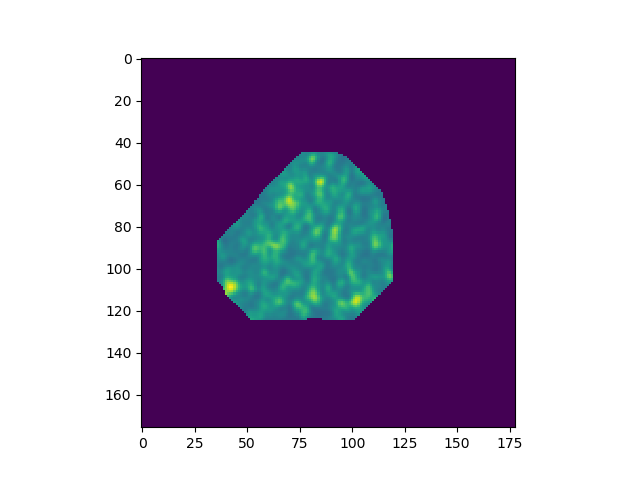

In [46]:
%matplotlib notebook 
plt.imshow(ch2[20])

In [45]:
cellData.to_csv(f'{bigDir}\\cellinfo_signals_v3.csv')

# 200203 segmentation: erosion

In [29]:
cellDataFile=f'{bigDir}\cellinfo_signals_v3.csv'

In [30]:
cellData=pd.read_csv(cellDataFile)

In [33]:
cellData=cellData.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'nucleus_Otsu_erosion_inner_9x5_volume','nucleus_Otsu_erosion_inner_9x5_ch1','nucleus_Otsu_erosion_inner_9x5_ch2',
                                'nucleus_Otsu_erosion_inner_9x5_ch3','nucleus_Otsu__erosion_outer_9x5_volume','nucleus_Otsu__erosion_outer_9x5_ch1',
                                'nucleus_Otsu__erosion_outer_9x5_ch2','nucleus_Otsu__erosion_outer_9x5_ch3',
                                'nucleus_Otsu_erosion_inner_13x8_volume','nucleus_Otsu_erosion_inner_13x8_ch1','nucleus_Otsu_erosion_inner_13x8_ch2',
                                'nucleus_Otsu_erosion_inner_13x8_ch3','nucleus_Otsu__erosion_outer_13x8_volume','nucleus_Otsu__erosion_outer_13x8_ch1',
                                'nucleus_Otsu__erosion_outer_13x8_ch2','nucleus_Otsu__erosion_outer_13x8_ch3'])

In [34]:
cellData.head()

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,HetChrom_erosion_outer_9x5_20_ch2,HetChrom_erosion_outer_9x5_20_ch3,HetChrom_erosion_inner_13x8_20_Volume,HetChrom_erosion_inner_13x8_20_ch1,HetChrom_erosion_inner_13x8_20_ch2,HetChrom_erosion_inner_13x8_20_ch3,HetChrom_erosion_outer_13x8_20_Volume,HetChrom_erosion_outer_13x8_20_ch1,HetChrom_erosion_outer_13x8_20_ch2,HetChrom_erosion_outer_13x8_20_ch3
0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,3,...,228838609.0,432481890.0,26649.0,446357009.0,287465992.0,6.059570e+08,25993.0,343851501.0,263052050.0,455215468.0
1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,329142731.0,725729186.0,43312.0,213222953.0,590747409.0,1.244767e+09,23896.0,109216346.0,305520069.0,567307181.0
2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,3,...,287673847.0,726762664.0,47734.0,234835439.0,538655494.0,1.343080e+09,18390.0,82981277.0,193831872.0,431364743.0
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,216267728.0,638330656.0,27674.0,267383771.0,259834011.0,8.486865e+08,17115.0,142672978.0,144109610.0,380441679.0
4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,3,...,272432111.0,473737399.0,30259.0,396907398.0,348189377.0,6.780964e+08,33201.0,363283873.0,348961386.0,583863832.0


In [24]:
new_filter=skmor.ball(1)
radius=1
while (new_filter.shape[0]<7):
    radius+=1
    new_filter=skmor.ball(radius)
    print(radius)
new_filter=np.delete(new_filter, [(0,1,5,6)], axis=0)

nine_filter=skmor.ball(1)
radius=1
while (nine_filter.shape[0]<9):
    radius+=1
    nine_filter=skmor.ball(radius)
    print(radius)
nine_filter=np.delete(nine_filter, [(0,1,2,6,7,8)], axis=0)

elv_filter=skmor.ball(1)
radius=1
while (elv_filter.shape[0]<11):
    radius+=1
    elv_filter=skmor.ball(radius)
    print(radius)
elv_filter=np.delete(elv_filter, [(0,1,2,7,8,9,10)], axis=0)

2
3
2
3
4
2
3
4
5


In [25]:
thr_filter=skmor.ball(1)
radius=1
while (elv_filter.shape[0]<13):
    radius+=1
    elv_filter=skmor.ball(radius)
    print(radius)
elv_filter=np.delete(elv_filter, [(0,1,2,3,4,8,9,10,11,12)], axis=0)

2
3
4
5
6


<IPython.core.display.Javascript object>


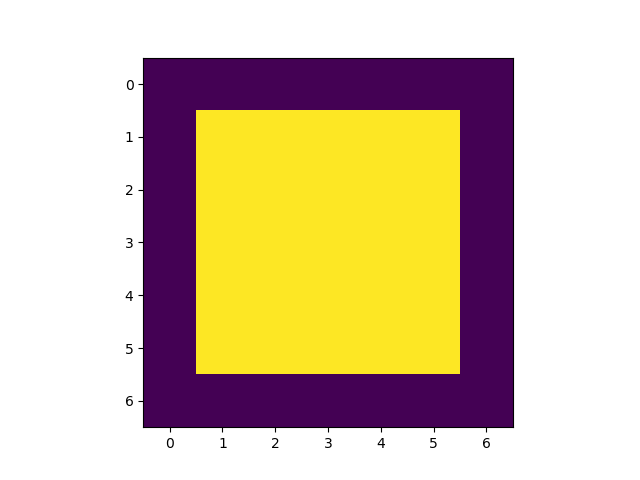

In [26]:
%matplotlib notebook
plt.imshow(new_filter[2])

In [11]:
df=pd.DataFrame(columns=['9x9','13x13','org','9^3','13^5', '13^8'])

# trying scipy.ndimage.morphology.binary_erosion with new filter

In [34]:
i=31

# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(cellData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,cell in islice(cellData.iterrows(),i,None):
    percentile = 20

    # open tiff image of a cell
    try:
        myImage=imread(cell.path) 
    except:
        cell.path=cell.path.replace('.tif','.tiff')
        myImage=imread(cell.path)
    myChannel = myImage[:, 1, :, :] #1st channel is hetChrom (as stained by HP1B or H3K9Me3)
    myNucChannel = myImage[:,2,:,:]
    # open nucleus mask
    nucleusMaskPath=cell.path
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    try:
        nucMask=imread(nucleusMaskPath)
    except:
        nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
        nucMask=imread(nucleusMaskPath)

    
    nucMask=nucMask.astype(bool)

    # open het mask - new control
    myHetMaskPath=cell.path
    myHetMaskPath=myHetMaskPath.replace('data_tiff',f'segmentation_{percentile}')
    myHetMaskPath=myHetMaskPath.replace('.tif','_hetChrom.tif')
    try:
        het=imread(myHetMaskPath)
    except:
        myHetMaskPath=myHetMaskPath.replace('.tiff','.tif')
        het=imread(myHetMaskPath)
    het=het.astype(bool)
    
    nucMask[nucMask==255]=1
    
    ### erosion
    copy_nuc=nucMask.copy()
    nin_fiv=br(nucMask, structure=nine_filter, iterations=5)
    thr_egt=br(nucMask, structure=thr_filter, iterations=8)

    ## masking 9x9 structure 
    nin_fiv=nin_fiv.astype(bool)
    try:
        nin_fiv_erode=het[nin_fiv]
    except:
        myHetMaskPath=myHetMaskPath.replace('.tiff','.tif')
        het=imread(myHetMaskPath)
        het=het.astype(bool)
        nin_fiv_erode=het[nin_fiv]

    
    hetInner_9x5=ma.zeros(het.shape)
    hetInner_9x5[nin_fiv]=nin_fiv_erode
    hetInner_9x5=hetInner_9x5.astype(bool)
    
    outerMask_9x5=nucMask.copy()
    outerMask_9x5[nin_fiv]=0
    hetOuter=het[outerMask_9x5]
    hetOuter_9x5=ma.zeros(het.shape)
    hetOuter_9x5[outerMask_9x5]=hetOuter
    hetOuter_9x5=hetOuter_9x5.astype(bool)
    
    ## masking 13x13 structure
    thr_egt=thr_egt.astype(bool)
    thr_egt_erode=het[thr_egt]
    hetInner_13x8=ma.zeros(het.shape)
    hetInner_13x8[thr_egt]=thr_egt_erode
    hetInner_13x8=hetInner_13x8.astype(bool)
    
    outerMask_13x8=nucMask.copy()
    outerMask_13x8[thr_egt]=0
    hetOuter=het[outerMask_13x8]
    hetOuter_13x8=ma.zeros(het.shape)
    hetOuter_13x8[outerMask_13x8]=hetOuter
    hetOuter_13x8=hetOuter_13x8.astype(bool)
    
    '''
    #####################################
    # saving image files
    newSegFolder = os.path.dirname(cell.path).replace('data_tiff','sphere_v2_final')
    try:
        os.mkdir(newSegFolder)
    except:
        pass
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_inner_mask_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), nin_fiv.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_outer_mask_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), outerMask_9x5.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_inner_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), hetInner_9x5.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_9^5_outer_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), hetOuter_9x5.astype('uint8'))
    
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_13^8_inner_mask_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), thr_egt.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_eroded_13^8_outer_mask_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), outerMask_13x8.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_het_eroded_13^8_inner_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), hetInner_13x8.astype('uint8'))
    maskFile = os.path.basename(cell.path).replace('.tif',f'_het_eroded_13^8_outer_{percentile}.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), hetOuter_13x8.astype('uint8'))
    ########################################
    
    #################calculating signals#######################
    
    #####HETEROCHROMATIN##### 
    df = pd.DataFrame(columns = [f'HetChrom_erosion_inner_9x5_{percentile}_Volume',f'HetChrom_erosion_inner_9x5_{percentile}_ch1',
                                 f'HetChrom_erosion_inner_9x5_{percentile}_ch2',f'HetChrom_erosion_inner_9x5_{percentile}_ch3',
                                f'HetChrom_erosion_outer_9x5_{percentile}_Volume',f'HetChrom_erosion_outer_9x5_{percentile}_ch1',
                                 f'HetChrom_erosion_outer_9x5_{percentile}_ch2',f'HetChrom_erosion_outer_9x5_{percentile}_ch3',
                                 
                                 f'HetChrom_erosion_inner_13x8_{percentile}_Volume',f'HetChrom_erosion_inner_13x8_{percentile}_ch1',
                                 f'HetChrom_erosion_inner_13x8_{percentile}_ch2',f'HetChrom_erosion_inner_13x8_{percentile}_ch3',
                                f'HetChrom_erosion_outer_13x8_{percentile}_Volume',f'HetChrom_erosion_outer_13x8_{percentile}_ch1',
                                 f'HetChrom_erosion_outer_13x8_{percentile}_ch2',f'HetChrom_erosion_outer_13x8_{percentile}_ch3'])

    df.Slice = range(myChannel.shape[0])
    df.HetChrom_erosion_inner_9x5_20_Volume =  hetInner_9x5.sum(-1).sum(-1)
    df.HetChrom_erosion_outer_9x5_20_Volume =  hetOuter_9x5.sum(-1).sum(-1)
    df.HetChrom_erosion_inner_13x8_20_Volume =  hetInner_13x8.sum(-1).sum(-1)
    df.HetChrom_erosion_outer_13x8_20_Volume =  hetOuter_13x8.sum(-1).sum(-1)

    myNucChannel2=np.copy(myNucChannel)
    
    
    for ch in range(3):
        
        # inner mask
        myChannel = np.copy(myImage[:, ch, :, :])
        myChannel[~hetInner_9x5] = 0
        signal = myChannel.sum(-1).sum(-1)
        #df[f'HetChrom_sphere_inner_20_ch{ch+1}']=signal
        exec(f'df.HetChrom_erosion_inner_9x5_{percentile}_ch{ch+1}=signal')
        
        # outer mask
        myChannel2 = np.copy(myImage[:, ch, :, :])
        myChannel2[~hetOuter_9x5] = 0
        signal2 = myChannel2.sum(-1).sum(-1)
        exec(f'df.HetChrom_erosion_outer_9x5_{percentile}_ch{ch+1}=signal2')
        
         # inner mask
        myChannel3 = np.copy(myImage[:, ch, :, :])
        myChannel3[~hetInner_13x8] = 0
        signal3 = myChannel3.sum(-1).sum(-1)
        exec(f'df.HetChrom_erosion_inner_13x8_{percentile}_ch{ch+1}=signal3')
        
        # outer mask
        myChannel4 = np.copy(myImage[:, ch, :, :])
        myChannel4[~hetOuter_13x8] = 0
        signal4 = myChannel4.sum(-1).sum(-1)
        exec(f'df.HetChrom_erosion_outer_13x8_{percentile}_ch{ch+1}=signal4')
        
    
    # save signals
    dfSavePath=cell.path
    dfSavePath=dfSavePath.replace('data_tiff','results')
    dfSavePath=dfSavePath.replace('.tif',f'_hetChrom_erosion_{percentile}.csv')
    df.to_csv(dfSavePath)
    
    # add info to cell info file
    
    for myMeasurement in df.columns:
        
        myString=f"cellData.loc[i,'{myMeasurement}']=np.sum(df.{myMeasurement})"
        exec(myString)

    cellData.loc[i,f'hetChrom_erosion_inner_9^5_{percentile}_volume']=np.sum(df.f'HetChrom_erosion_inner_9^5_{percentile}_Volume')
    cellData.loc[i,f'hetChrom_erosion_outer_9^5_{percentile}_volume']=np.sum(df.f'HetChrom_erosion_outer_9^5_{percentile}_Volume')
    cellData.loc[i,f'hetChrom_erosion_inner_13^8_{percentile}_volume']=np.sum(df.f'HetChrom_erosion_inner_13^8_{percentile}_Volume')
    cellData.loc[i,f'hetChrom_erosion_outer_13^8_{percentile}_volume']=np.sum(df.f'HetChrom_erosion_outer_13^8_{percentile}_Volume')

    for ch in range(3):
        exec(f"cellData.loc[i,'hetChrom_erosion_inner_9^5_{percentile}_ch{ch+1}']=np.sum(df.HetChrom_erosion_inner_9^5_{percentile}_ch{ch+1})") 
        exec(f"cellData.loc[i,'hetChrom_erosion_outer_9^5_{percentile}_ch{ch+1}']=np.sum(df.HetChrom_erosion_outer_9^5_{percentile}_ch{ch+1})") 
        exec(f"cellData.loc[i,'hetChrom_erosion_inner_13^8_{percentile}_ch{ch+1}']=np.sum(df.HetChrom_erosion_inner_13^8_{percentile}_ch{ch+1})") 
        exec(f"cellData.loc[i,'hetChrom_erosion_outer_13^8_{percentile}_ch{ch+1}']=np.sum(df.HetChrom_erosion_outer_13^8_{percentile}_ch{ch+1})") 
    '''
    
    #####NUCLEUS#####
    # open tiff image of a cell
    myImage=imread(cell.path)    
    ch1 = myImage[:, 1, :, :] #1st channel - hetChrom (as stained by HP1B or H3K9Me3)
    ch2 = myImage[:, 0, :, :] #2nd channel - MCM
    ch3 = myImage[:, 2, :, :] #3rd channel - DAPI
    ch1_1=ch1.copy()
    ch2_1=ch2.copy()
    ch3_1=ch3.copy()
    # dataframe
    df = pd.DataFrame(columns = ['nucleus_Otsu_erosion_inner_9x5_volume','nucleus_Otsu_erosion_inner_9x5_ch1',
                                 'nucleus_Otsu_erosion_inner_9x5_ch2','nucleus_Otsu_erosion_inner_9x5_ch3',
                                'nucleus_Otsu_erosion_outer_9x5_volume','nucleus_Otsu_erosion_outer_9x5_ch1',
                                 'nucleus_Otsu_erosion_outer_9x5_ch2','nucleus_Otsu_erosion_outer_9x5_ch3',
                                
                                'nucleus_Otsu_erosion_inner_13x8_volume','nucleus_Otsu_erosion_inner_13x8_ch1',
                                 'nucleus_Otsu_erosion_inner_13x8_ch2','nucleus_Otsu_erosion_inner_13x8_ch3',
                                'nucleus_Otsu_erosion_outer_13x8_volume','nucleus_Otsu_erosion_outer_13x8_ch1',
                                 'nucleus_Otsu_erosion_outer_13x8_ch2','nucleus_Otsu_erosion_outer_13x8_ch3'])
    
    # calculate signals
    masks=['nin_fiv','outerMask_9x5','thr_egt','outerMask_13x8']
    masksNames=['nucleus_Otsu_erosion_inner_9x5', 'nucleus_Otsu_erosion_outer_9x5', 'nucleus_Otsu_erosion_inner_13x8',
               'nucleus_Otsu_erosion_outer_13x8']
    signals=[None,'ch1','ch2','ch3']
    signalsNames=['volume','ch1','ch2','ch3']
    
    df.Slice = range(ch1.shape[0])
    
    for myMask,myMaskName in zip(masks,masksNames):
        
        for mySignal,mySignalName in zip(signals,signalsNames):
            ch1=ch1_1.copy()
            ch2=ch2_1.copy()
            ch3=ch3_1.copy()
            if mySignal is None:
                mySignal=myMask
                
            myString=f'{mySignal}[~{myMask}]=0'
           
            exec(myString)
            myString=f'df.{myMaskName}_{mySignalName}={mySignal}.sum(-1).sum(-1)'
            exec(myString)
            

    
    # save signals (per frame)
    dfSavePath=cell.path
    dfSavePath=dfSavePath.replace('data_tiff','results')
    dfSavePath=dfSavePath.replace('.tif',f'_nuc_otsu_erosion.csv')
    df.to_csv(dfSavePath)

    # add info to cell info file
    for myMeasurement in df.columns:
        
        myString=f"cellData.loc[i,'{myMeasurement}']=np.sum(df.{myMeasurement})"
        exec(myString)
    
    print(i)
    progBar.value=progBar.value+1
    
    break

IntProgress(value=31, description='Progress:', max=324)

31


C:\ProgramData\Anaconda3_reinstalled\lib\site-packages\ipykernel_launcher.py:221: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [84]:
cell.path

'Z:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\new dataset\\20191203_cellde\\data_tiff\\20191203_cellde-32.tiff'

In [85]:
het.shape

(33, 380, 380)

In [87]:
myHetMaskPath

'Z:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\new dataset\\20191203_cellde\\segmentation_20\\20191203_cellde-32_hetChrom.tif'

In [39]:
cellData

,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,DAPI ch,...,nucleus_Otsu_erosion_outer_9x5_ch2,nucleus_Otsu_erosion_outer_9x5_ch3,nucleus_Otsu_erosion_inner_13x8_volume,nucleus_Otsu_erosion_inner_13x8_ch1,nucleus_Otsu_erosion_inner_13x8_ch2,nucleus_Otsu_erosion_inner_13x8_ch3,nucleus_Otsu_erosion_outer_13x8_volume,nucleus_Otsu_erosion_outer_13x8_ch1,nucleus_Otsu_erosion_outer_13x8_ch2,nucleus_Otsu_erosion_outer_13x8_ch3
0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,3,...,1.845034e+09,2.124247e+09,41993.0,379110796.0,692173025.0,9.355449e+08,221201.0,1.036066e+09,1.881193e+09,2.152830e+09
1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,3,...,1.172988e+09,4.333228e+09,96188.0,928262052.0,479454971.0,2.776081e+09,239801.0,1.246754e+09,1.078063e+09,3.651188e+09
2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,3,...,1.084929e+09,4.230824e+09,94623.0,831896937.0,457256707.0,2.741925e+09,235927.0,1.101104e+09,1.005379e+09,3.485042e+09
3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,3,...,1.317163e+09,2.766073e+09,46882.0,355031477.0,451306388.0,1.405849e+09,176987.0,7.071109e+08,1.137858e+09,2.205521e+09
4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20191203_cell-05.czi,20191125-01-36,191125pcnat_dhbr_cdc6vxy01,1705.099,468.246,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20191203_cell-06.czi,20191125-01-37,191125pcnat_dhbr_cdc6vxy01,234.034,482.620,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20191203_cell-07.czi,20191125-01-40,191125pcnat_dhbr_cdc6vxy01,451.617,514.260,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20191203_cell-08.czi,20191125-01-41,191125pcnat_dhbr_cdc6vxy01,332.674,553.990,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20191203_cell-09.czi,20191125-01-45,191125pcnat_dhbr_cdc6vxy01,781.494,661.685,MCM3,1,HP1beta,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
i

193

In [41]:
cellData.to_csv(f'{bigDir}\\cellinfo_signals_v3.csv')

In [93]:
cellData=pd.read_csv(f'{bigDir}\\cellinfo_signals_v3.csv')

In [ ]:
cellData['age_track']=cellData['physical age']/60

# 200207 modifying category values

In [3]:
cellDataFile=f'{bigDir}\\cellinfo_signals_v3.csv'

In [4]:
cellData=pd.read_csv(cellDataFile)

In [24]:
for i, cell in cellData.iterrows():
    cellData.at[i, 'category']=cellData.at[i, 'category'].replace(" ","")

In [25]:
cellData.category

0      middleG1
1            G2
2            G2
3       earlyG1
4      middleG1
5       earlyG1
6        lateG1
7        lateG1
8      middleG1
9       earlyG1
10      earlyG1
11     middleG1
12     middleG1
13       earlyS
14     middleG1
15     middleG1
16     middleG1
17      earlyG1
18      earlyG1
19      earlyG1
20       earlyS
21      earlyG1
22     middleG1
23     middleG1
24           G2
25       earlyS
26      earlyG1
27           G2
28      earlyG1
29      earlyG1
         ...   
294    middleG1
295    middleG1
296      earlyS
297      earlyS
298      earlyS
299      earlyS
300      lateG1
301      lateG1
302    middleG1
303    middleG1
304          G0
305          G0
306          G0
307          G0
308          G0
309          G0
310          G0
311          G0
312          G0
313          G0
314          G0
315          G0
316          G0
317          G0
318          G0
319          G0
320          G0
321          G0
322          G0
323          G0
Name: category, Length: 

In [26]:
cellData.to_csv(f'{bigDir}\\cellinfo_signals_v3.csv')

# 200214 fixing miscalculated het values

from the file 200210_signal_analysis_doodle 
index 29, 31, 193 cell file's het values were miscalculated

In [9]:
cellDataFile=f'{bigDir}\cellinfo_signals_v3.csv'
cellData=pd.read_csv(cellDataFile)
cellData.head()

,Unnamed: 0,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,...,nucleus_Otsu_erosion_outer_9x5_ch2,nucleus_Otsu_erosion_outer_9x5_ch3,nucleus_Otsu_erosion_inner_13x8_volume,nucleus_Otsu_erosion_inner_13x8_ch1,nucleus_Otsu_erosion_inner_13x8_ch2,nucleus_Otsu_erosion_inner_13x8_ch3,nucleus_Otsu_erosion_outer_13x8_volume,nucleus_Otsu_erosion_outer_13x8_ch1,nucleus_Otsu_erosion_outer_13x8_ch2,nucleus_Otsu_erosion_outer_13x8_ch3
0,0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,...,1845034250,2124247232,41993,379110796.0,692173025.0,935544913,221201,1036065660,1881193437,2152830246
1,1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,...,1172988453,4333228408,96188,928262052.0,479454971.0,2776081300,239801,1246753636,1078063100,3651188242
2,2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,...,1084928746,4230824260,94623,831896937.0,457256707.0,2741925173,235927,1101103949,1005378808,3485041772
3,3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,...,1317163099,2766073336,46882,355031477.0,451306388.0,1405848914,176987,707110878,1137858410,2205521063
4,4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,...,1855532711,2450389960,46268,442817486.0,585059149.0,990267188,270946,1275070823,1982458425,2634827813


In [48]:
i=29
het_percentile=20
# Progress Bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(cellData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)

for i,myCell in islice(cellData.iterrows(), i,None):

    # create folder to store this percentile data if it doesn't exist yet
    newSegFolder = os.path.dirname(myCell.path).replace('data_tiff',f'segmentation_{het_percentile}')
    newResultsFolder = os.path.dirname(myCell.path).replace('data_tiff', 'results')
    
    try:
        os.mkdir(newSegFolder)
    except:
        pass
    
    try:
        os.mkdir(newResultsFolder)
    except:
        pass

    
    # open tiff image of a cell
    try:
        myImage=imread(myCell.path)    
    except:
        myCell.path=myCell.path.replace('.tif','.tiff')
        myImage=imread(myCell.path)    


    myChannel = myImage[:, 1, :, :] #2nd channel is hetChrom (as stained by HP1B or H3K9Me3)

    # open nucleus mask
    nucleusMaskPath=myCell.path
    nucleusMaskPath=nucleusMaskPath.replace('data_tiff','segmentation_nucleus_Otsu')
    nucleusMaskPath=nucleusMaskPath.replace('.tif','_nucleus.tif')
    try:
        nucleusMask=imread(nucleusMaskPath)
    except:
        nucleusMaskPath=nucleusMaskPath.replace('.tiff','.tif')
        nucleusMask=imread(nucleusMaskPath)


    # make nucleus mask binary
    nucleusMask = nucleusMask.astype(bool)

    # clean image
    myNucleus = myChannel[nucleusMask]

    # find threshold
    myPercentile = np.nanpercentile(myNucleus, (100-het_percentile)) 

    # threshold
    myHetMask=np.zeros(myChannel.shape).astype('bool')
    myHetMask[myChannel >= myPercentile] = 1
    
    # clean from elements outside the nucleus
    cleanNucleusMask=~nucleusMask
    myHetMask[cleanNucleusMask]=0
    cleanHetMask = ~myHetMask

    # save segmentation mask
    maskFile = os.path.basename(myCell.path).replace('.tif',f'_hetChrom.tif')
    tifffile.imsave(os.path.join(newSegFolder,maskFile), myHetMask.astype('uint8'))

    # calculate signals
    df = pd.DataFrame(columns = ['HetChrom_Volume','HetChrom_total_ch1','HetChrom_total_ch2','HetChrom_total_ch3',
                                 'Slice'])

    df.Slice = range(myChannel.shape[0])
    df.HetChrom_Volume =  myHetMask.sum(-1).sum(-1)

    for ch in range(3):
        myChannel = myImage[:, ch, :, :]
        myChannel[cleanHetMask] = 0
        signal = myChannel.sum(-1).sum(-1)
        exec(f'df.HetChrom_total_ch{ch}=signal')

    # save signals
    dfSavePath=myCell.path
    dfSavePath=dfSavePath.replace('data_tiff','results')
    dfSavePath=dfSavePath.replace('.tif',f'_hetChrom_{str((het_percentile))}.csv')
    df.to_csv(dfSavePath)

    # add info to cell info file
    cellData.loc[i,f'hetChrom_{str(het_percentile)}_volume']=np.sum(df.HetChrom_Volume)
    for ch in range(3):
        exec(f"cellData.loc[i,'hetChrom_{str(het_percentile)}perc_ch{ch+1}']=np.sum(df.HetChrom_total_ch{ch})") 

    print("ch1 ", np.sum(df.HetChrom_total_ch1))
    progBar.value=progBar.value+1
    
    break

IntProgress(value=29, description='Progress:', max=324)

ch1 233585774


C:\ProgramData\Anaconda3_reinstalled\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [32]:
myChannel=myImage[:,0,:,:]

In [ ]:
m

<IPython.core.display.Javascript object>


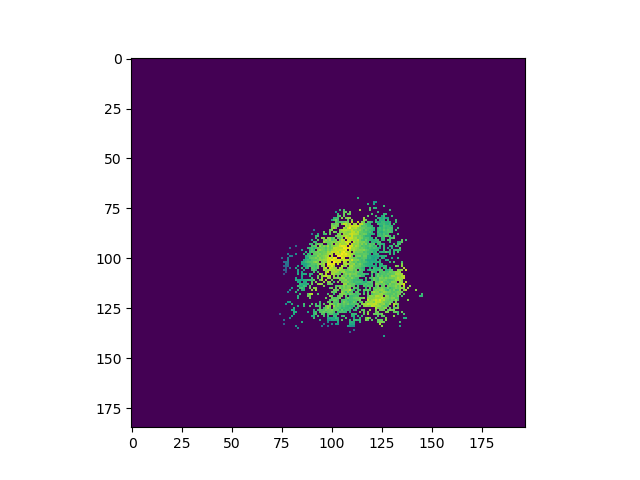

In [36]:
%matplotlib notebook
plt.imshow(myChannel[20])

<IPython.core.display.Javascript object>


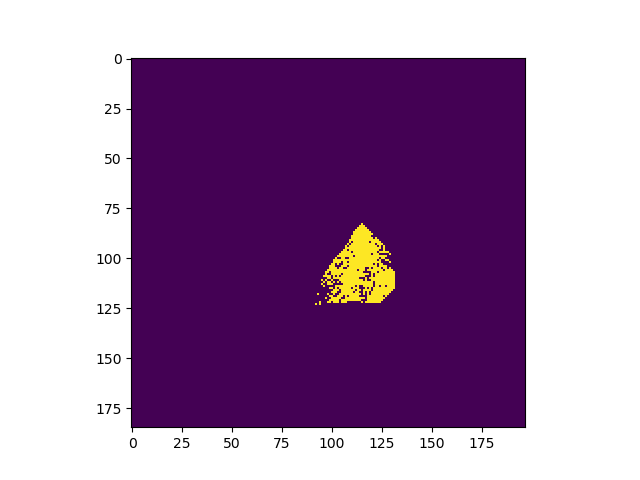

In [37]:
%matplotlib notebook 
plt.imshow(hetInner_9x5[20])

<IPython.core.display.Javascript object>


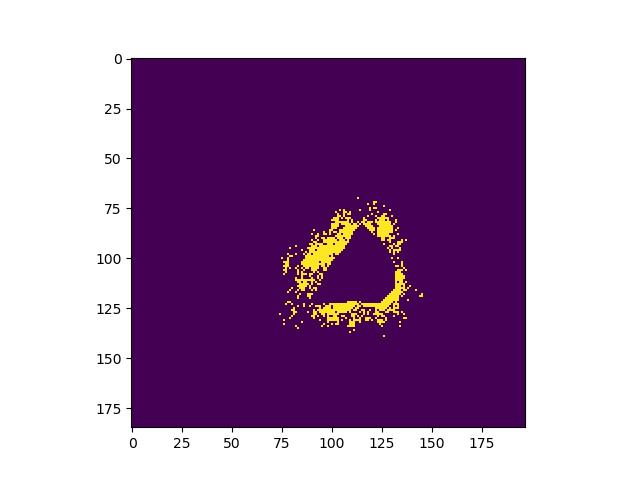

In [38]:
%matplotlib notebook 
plt.imshow(hetOuter_9x5[20])

In [22]:
cellData.head()

,Unnamed: 0,file,original cell name,movie,last frame movie position x,last frame movie position y,ab1 (MCM),ab1 ch,ab2 (heterochromatin),ab2 ch,...,nucleus_Otsu_erosion_outer_9x5_ch2,nucleus_Otsu_erosion_outer_9x5_ch3,nucleus_Otsu_erosion_inner_13x8_volume,nucleus_Otsu_erosion_inner_13x8_ch1,nucleus_Otsu_erosion_inner_13x8_ch2,nucleus_Otsu_erosion_inner_13x8_ch3,nucleus_Otsu_erosion_outer_13x8_volume,nucleus_Otsu_erosion_outer_13x8_ch1,nucleus_Otsu_erosion_outer_13x8_ch2,nucleus_Otsu_erosion_outer_13x8_ch3
0,0,20191203_cell-00.czi,20191125-01-17,191125pcnat_dhbr_cdc6vxy01,678.301,200.931,MCM3,1,HP1beta,2,...,1845034250,2124247232,41993,379110796.0,692173025.0,935544913,221201,1036065660,1881193437,2152830246
1,1,20191203_cell-01.czi,20191125-01-20,191125pcnat_dhbr_cdc6vxy01,1552.152,240.479,MCM3,1,HP1beta,2,...,1172988453,4333228408,96188,928262052.0,479454971.0,2776081300,239801,1246753636,1078063100,3651188242
2,2,20191203_cell-02.czi,20191125-01-23,191125pcnat_dhbr_cdc6vxy01,1131.436,318.530,MCM3,1,HP1beta,2,...,1084928746,4230824260,94623,831896937.0,457256707.0,2741925173,235927,1101103949,1005378808,3485041772
3,3,20191203_cell-03.czi,20191125-01-25,191125pcnat_dhbr_cdc6vxy01,1650.585,324.968,MCM3,1,HP1beta,2,...,1317163099,2766073336,46882,355031477.0,451306388.0,1405848914,176987,707110878,1137858410,2205521063
4,4,20191203_cell-04.czi,20191125-01-32,191125pcnat_dhbr_cdc6vxy01,1466.687,426.815,MCM3,1,HP1beta,2,...,1855532711,2450389960,46268,442817486.0,585059149.0,990267188,270946,1275070823,1982458425,2634827813


In [19]:
cellData.to_csv(f'{bigDir}\cellinfo_signals_v3.csv')